In [1]:
# Data wrangling
import numpy as np
import pandas as pd

# DataViz
import matplotlib.pyplot as plt
import seaborn as sns

# Statistics
from dython.nominal import associations
from scipy.stats import spearmanr, f_oneway, ttest_ind

# Data Wrangling
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import SelectFromModel
from scipy.cluster.hierarchy import linkage, dendrogram, distance

# Models 
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import lightgbm as lgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Model evaluation
from sklearn import metrics

# Parameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Notebook display
from IPython.core.display import HTML

In [2]:
# Seaborn settings
sns.set_theme(
    context="notebook",
    style="ticks",
    palette="colorblind",
    font_scale=.8, 
    rc = {
        "axes.grid": False,
        "grid.alpha": .2,
        "axes.titlesize": "x-large",
        "axes.titleweight": "bold",
        "axes.titlepad": 20
    }
)

In [3]:
# Function to display tables side by side
# https://stackoverflow.com/questions/38783027/jupyter-notebook-display-two-pandas-tables-side-by-side
def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += (
            df
            .style.set_table_attributes("style='display:inline'")
            .background_gradient(cmap="Blues")
            .set_caption(caption)._repr_html_()
            )
        output += "\xa0\xa0\xa0"
    display(HTML(output))

<h1> Churn Prediction Notebook - CRISP-DM</h1>

This notebook aims to show CRISP-DM process in a churn prediction case with its steps and its inputs and outputs.

# 1 - Business Understanding

## 1.1 - Churn Prediction

Churn prediction is related to detection of which customers tend to cancel a service. Companies spend money to acquire new clients, so clients losses represent investment lost. Retaining clients can be less expensive that acquiring new clients.

**Source**: https://www.avaus.com/blog/predicting-customer-churn/#:~:text=Churn%20prediction%20means%20detecting%20which,more%20than%20retaining%20existing%20ones

## 1.2 - Objectives
In addiction to accuracy, another metrics must be analyzed. It is important to predict churn, but expending money to retain a client that aren't churn must be avoided. Therefore, in addition to accuracy the following metrics with its respectives lower limits will be considered:

# 2 - Data Understanding

## 2.1 - Data Loading

In [4]:
df = pd.read_excel("churn_data.xlsx")
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## 2.2 - Initial Exploration

In [5]:
# Showing DataFrame information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7032 entries, 0 to 7031
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7032 non-null   object 
 1   gender            7032 non-null   object 
 2   SeniorCitizen     7032 non-null   int64  
 3   Partner           7032 non-null   object 
 4   Dependents        7032 non-null   object 
 5   tenure            7032 non-null   int64  
 6   PhoneService      7032 non-null   object 
 7   MultipleLines     7032 non-null   object 
 8   InternetService   7032 non-null   object 
 9   OnlineSecurity    7032 non-null   object 
 10  OnlineBackup      7032 non-null   object 
 11  DeviceProtection  7032 non-null   object 
 12  TechSupport       7032 non-null   object 
 13  StreamingTV       7032 non-null   object 
 14  StreamingMovies   7032 non-null   object 
 15  Contract          7032 non-null   object 
 16  PaperlessBilling  7032 non-null   object 


The dataset hasn't NaN data

We have decreased the DataFrame size by changing object to category.

In [6]:
# Showing DataFrame statistics
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000,7032.000000
mean,0.162400,32.421786,64.798208,2283.300441
std,0.368844,24.545260,30.085974,2266.771362
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.587500,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.862500,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


In [7]:
# Feature SeniorCitizen clearly must be treated as categorical
print(df["SeniorCitizen"].unique())

# Before outliers analysis, converting SeniorCitizen to category data type
df["SeniorCitizen"] = df["SeniorCitizen"].astype("category")

# Selecting numerical and categorical columns after converting SeniorCitizen
num_cols = df.select_dtypes("number").columns.to_list()
cat_cols = (
                df.select_dtypes(exclude="number")
                .columns.drop(labels=["customerID", "Churn"])
                .to_list()
            )

# Converting categorical features into category
df[cat_cols] = df[cat_cols].astype("category")

[0 1]


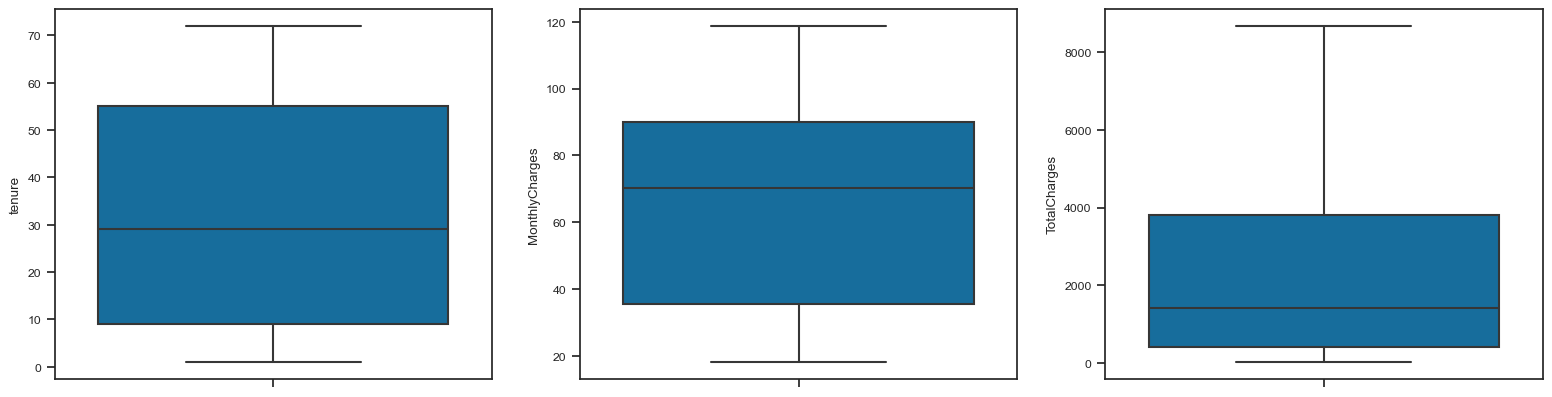

In [8]:
# Plotting boxplot for outliers detection and distribution analysis
fig, axes = plt.subplots(ncols=3, figsize=(6.4*3, 4.8))
for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, y=col, ax=ax, showfliers=True)

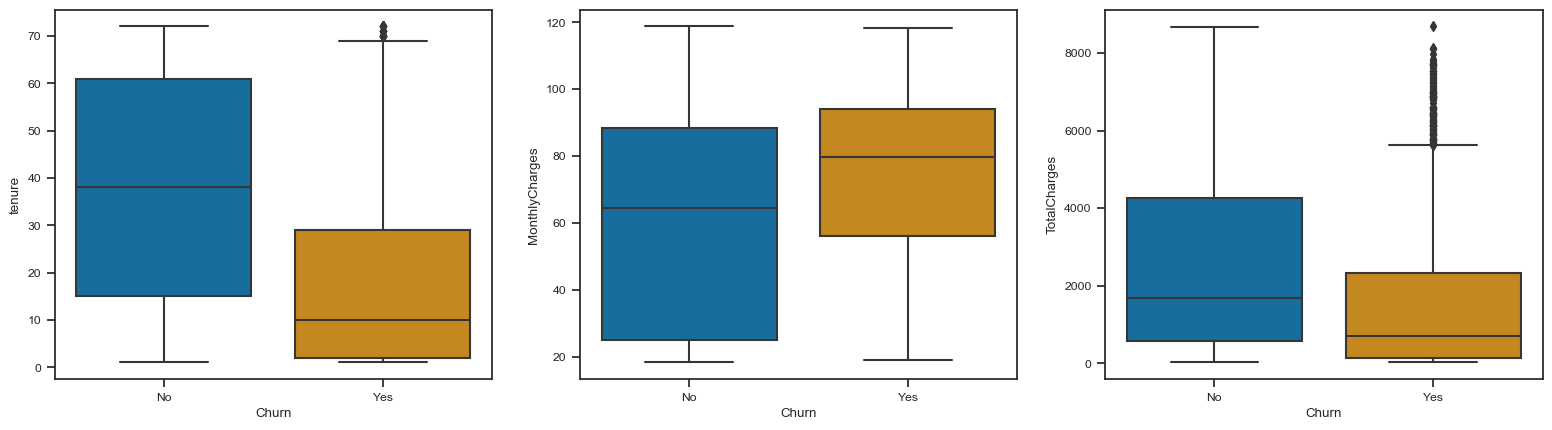

In [9]:
# Plotting boxplot for outliers detection and distribution analysis by churn target
fig, axes = plt.subplots(ncols=3, figsize=(6.4*3, 4.8))
for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, y=col, x="Churn", ax=ax, showfliers=True)

<Axes: xlabel='Churn', ylabel='count'>

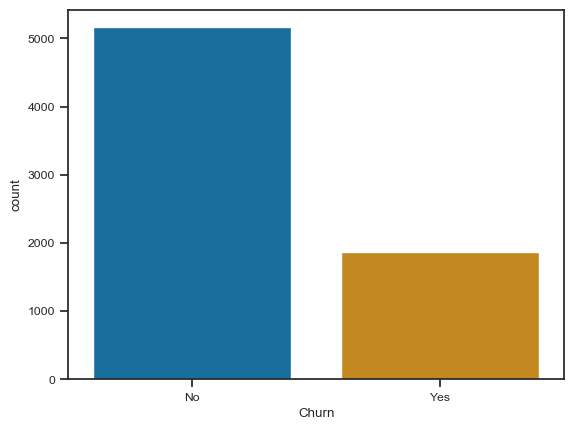

In [10]:
# Proportion of churn and no churn in the dataset
churn_values = df["Churn"].map({"No": 0, "Yes": 1})
sns.countplot(data=df, x="Churn")

## 2.3 - Initial Exploration Report

- There isn't NaN values;
- There isn't outliers following IQR method when analysing all rows of numerical features;
- When splitting numerical features by target feature, we have outliers in "yes" category;
- Numerical features must be standardized;
- Categorical features must be encoded for training models;
- There are only three numerical features: Tenure, MonthlyCharges and TotalCharges.

# 3 - Data Preparation

According to Initial Exploration Report isn't necessary to deal with NaN values. The creation of new values will be considered according to Models Evaluation Report.

## 3.1 - Association

To test the association between categorical features we will use Cramer's V and Theil's U tests with Dython Library. Explanations off these tests and Dython can be read in following articles:  
  
**The Search for Categorical Correlation**: <url>https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9</url>  
**Generate Numerical Correlation and Nominal Association Plots using Python**: <url>https://onezero.blog/generate-numerical-correlation-and-nominal-association-plots-using-python/</url>


### 3.1.1 - Categorical x Categorical association

To analyse and compute association between categorical features we will use data visualization and the tests Cramers'V and Theils'U.
Cramers'V and Theils'U are computed via dython library>

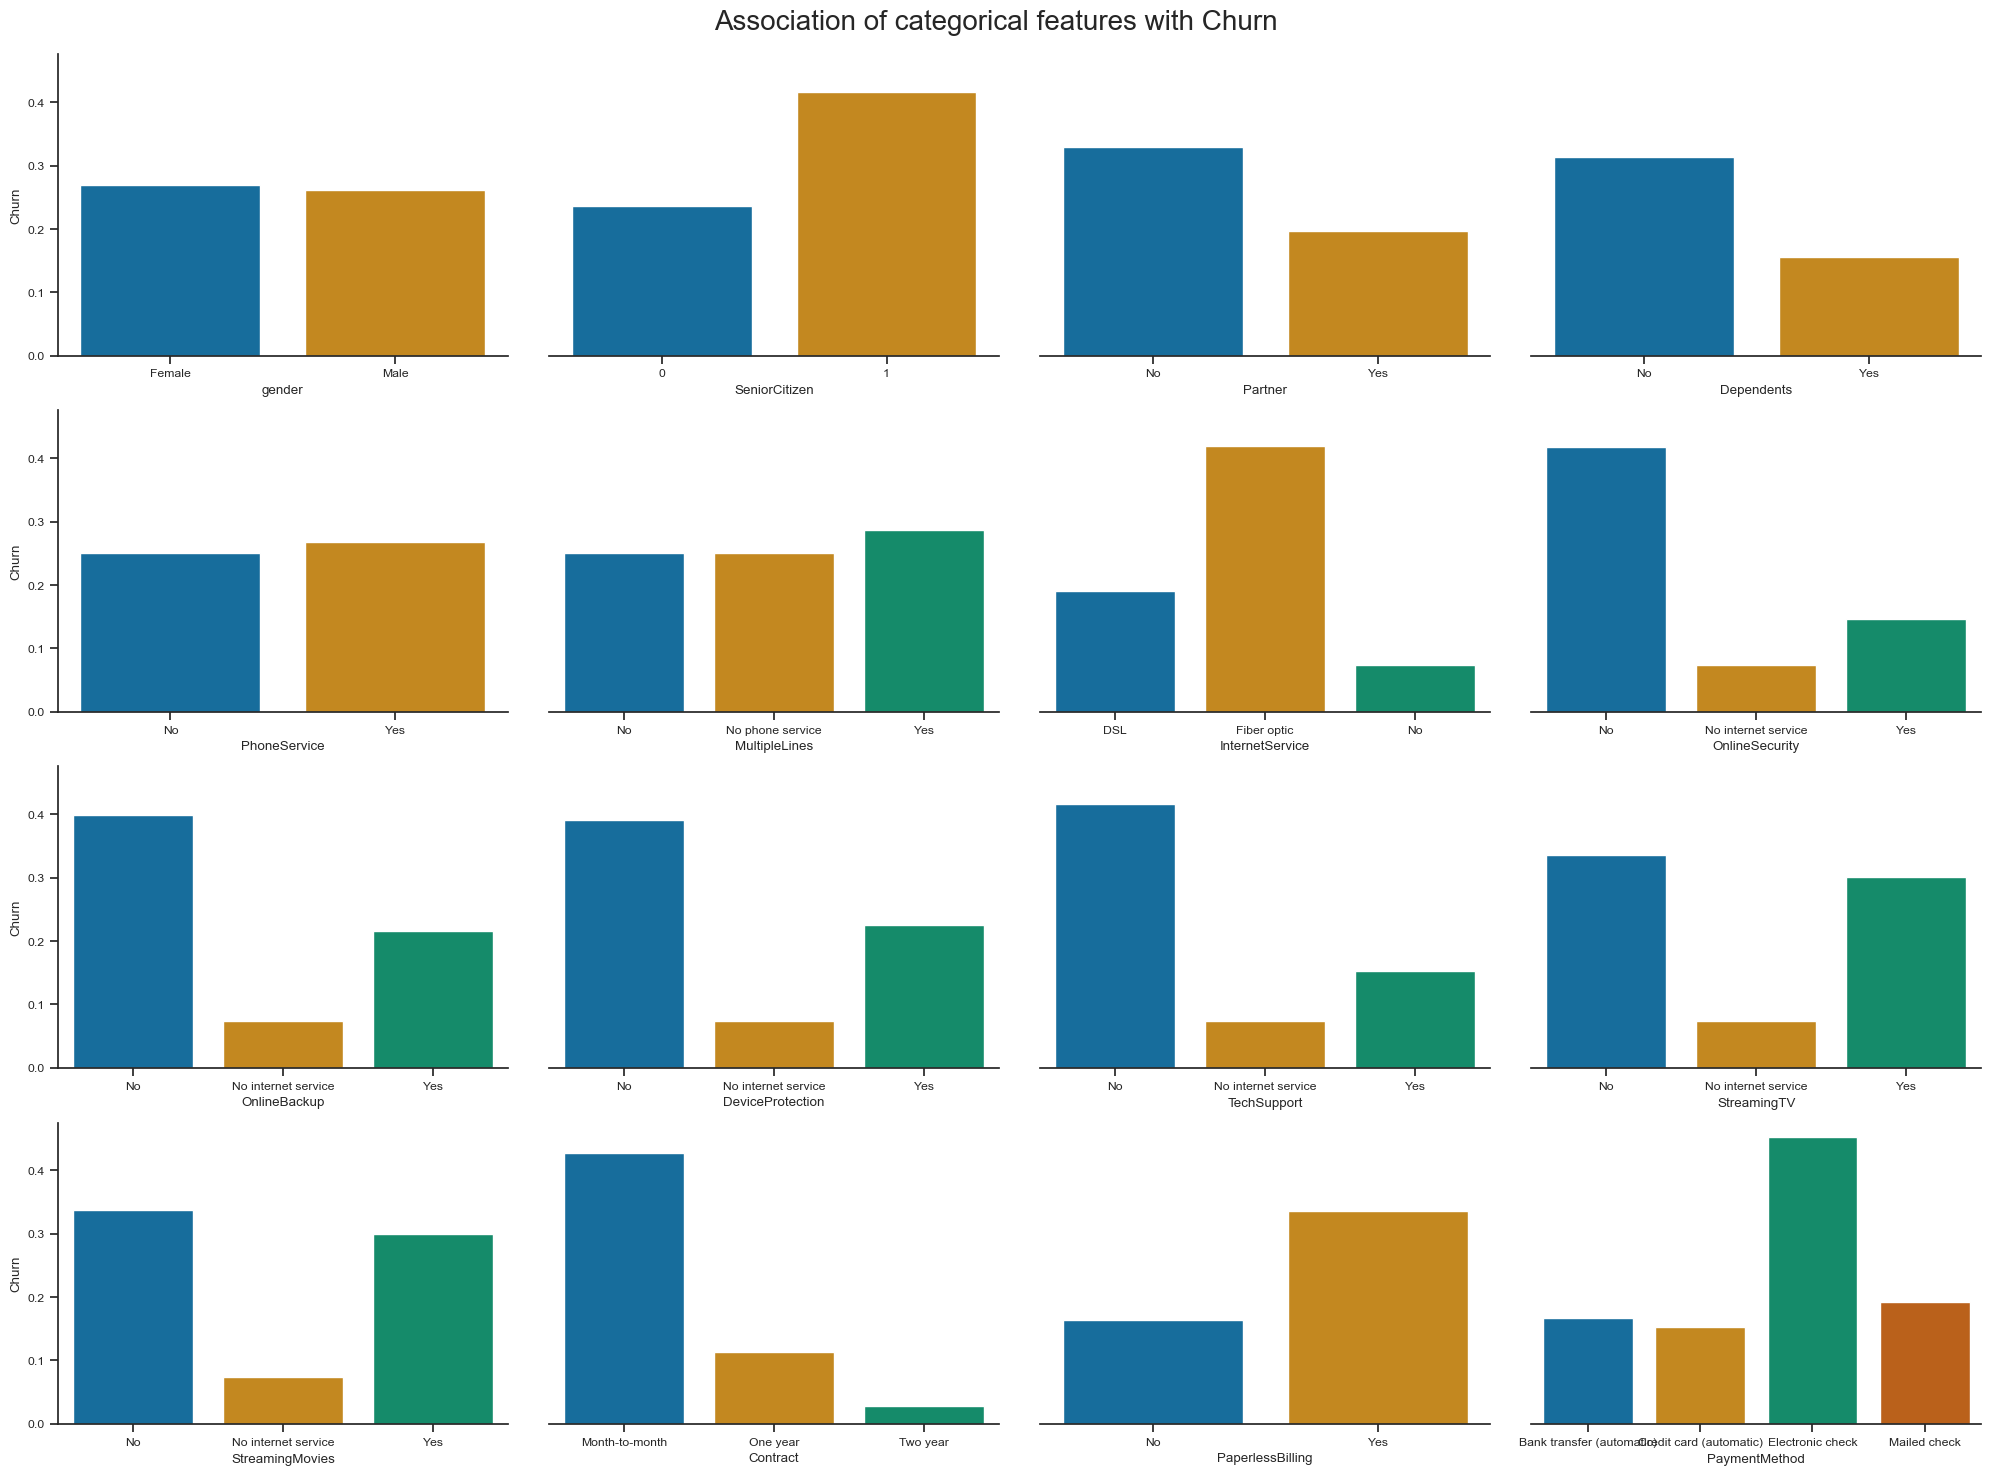

In [11]:
# Visualizing influence of categories on Churn via barplot
ncols = 4
nrows = np.ceil(len(cat_cols) / ncols).astype(int)
fig, axes = plt.subplots(figsize=(20, 15), nrows=nrows, ncols=ncols, sharey=True)
axes = axes.flatten()
for i, col in enumerate(cat_cols):
    sns.barplot(data=df, x=col, y=df["Churn"].map({"No": 0, "Yes": 1}).astype("int64"),
                ax=axes[i], errorbar=None)
    axes[i].set_ylabel("")
    axes[i].spines["top"].set_visible(False)
    axes[i].spines["right"].set_visible(False)
    if i % ncols == 0:
        axes[i].set_ylabel("Churn")
    else:
        axes[i].spines["left"].set_visible(False)
        axes[i].tick_params(axis="y", which="both", left=False)

for ax in axes[len(cat_cols):]:
    ax.set_axis_off()
    
fig.suptitle(f"Association of categorical features with Churn", size=20)
fig.tight_layout()
fig.subplots_adjust(top=.95)

In graphic above, the categories that seems to be more associeated with Churn are:
- InternetService;
- OnlineSecurity;
- TechSupport;
- Contract;
- PaymentMethod.

For categorical x categorical analysis, Cramer's V and Theil's U tests will be used. These tests are better explained in following links:  
 <url>https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9</url>  
 <url>https://onezero.blog/generate-numerical-correlation-and-nominal-association-plots-using-python/</url>

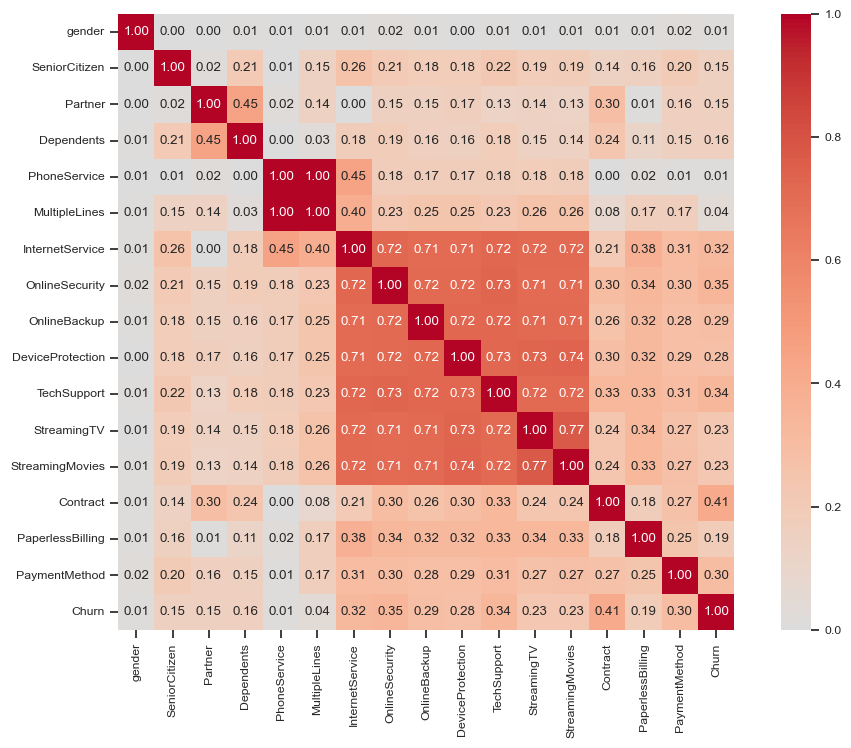

In [12]:
# Cramers's V heatmap
fig, ax = plt.subplots(figsize=(12, 8))
cramers_v = associations(pd.concat([df[cat_cols], df["Churn"].astype("category")], axis=1),
                         nom_nom_assoc="cramer",
                         ax=ax,
                         cramers_v_bias_correction=False,
                         cmap="coolwarm"
                        )

In graphic above, the categories that seems to be more associeated with Churn are:
- Contract;
- OnlineSecurity;
- TechSupport;
- InternetService;
- PaymentMethod.

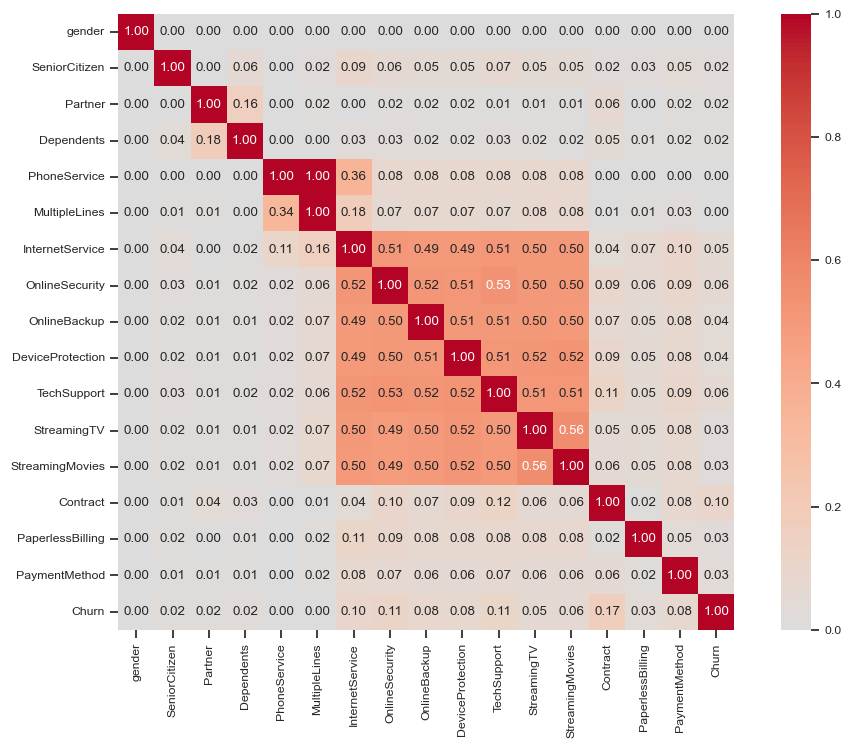

In [13]:
# Theil's U heatmap
fig, ax = plt.subplots(figsize=(12, 8))
cramers_v = associations(pd.concat([df[cat_cols], df["Churn"].astype("category")], axis=1),
                         nom_nom_assoc="theil",
                         ax=ax,
                         cmap="coolwarm"
                        )

We have significant association between the following features according to Cramer's V and Theil's U test,:
- InternetService;
- OnlineSecurity;
- OnlineBackup;
- DeviceProtection;
- TechSupport;
- StreamingTv;
- StreamingMovies.

We can test model only with TechSupport for study purposes. 

In [14]:
# Categorical cols to drop
cat_cols2drop = ["InternetService",
                 "OnlineSecurity",
                 "OnlineBackup",
                 "DeviceProtection",
                 "StreamingTv",
                 "StreamingMovies"]

### 3.1.2 - Numerical x Categorical Association

To verify association between numerical and categorical variables, ANOVA (analysis of variance) and t-test will be used. For more details, I recommend the following link:  
<url>http://www.sefidian.com/2020/08/02/measure-the-correlation-between-numerical-and-categorical-variables-and-the-correlation-between-two-categorical-variables-in-python-chi-square-and-anova/</url>

Before implementing ANOVA and T-test, we will see how numerical features are distributed by categories.

In [15]:
round((len(cat_cols) + 1) / ncols +.5) 

5

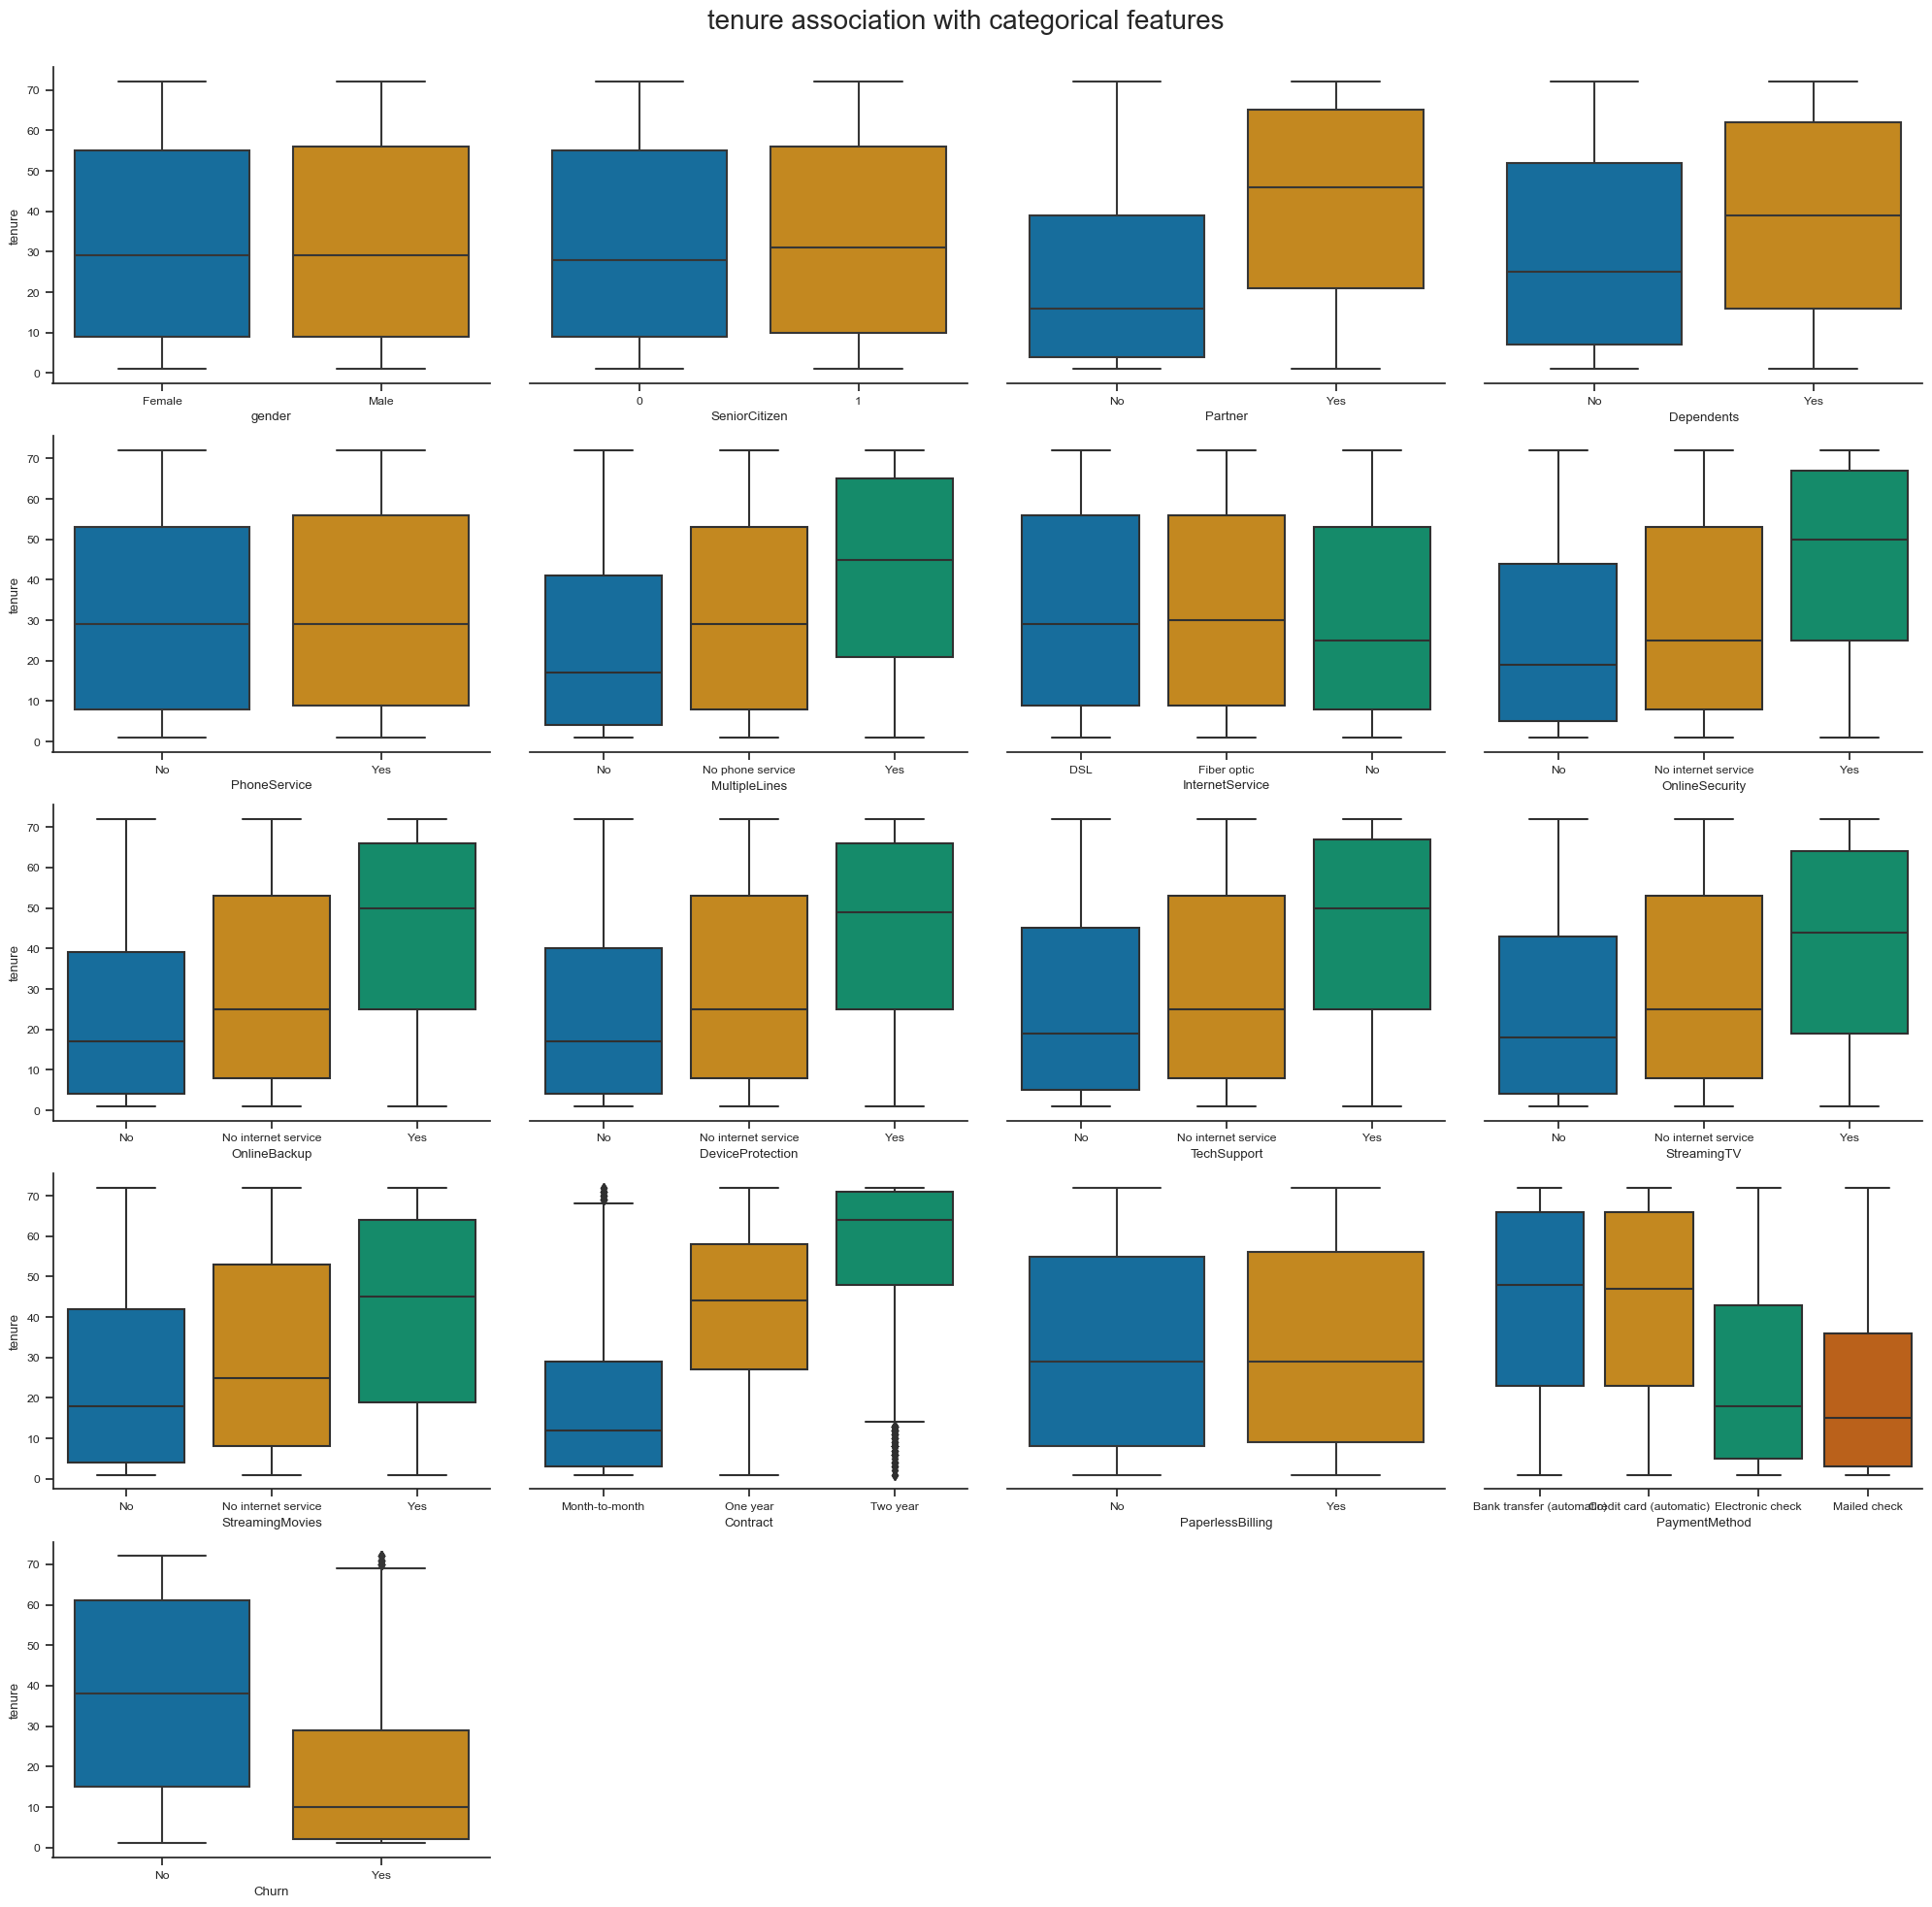

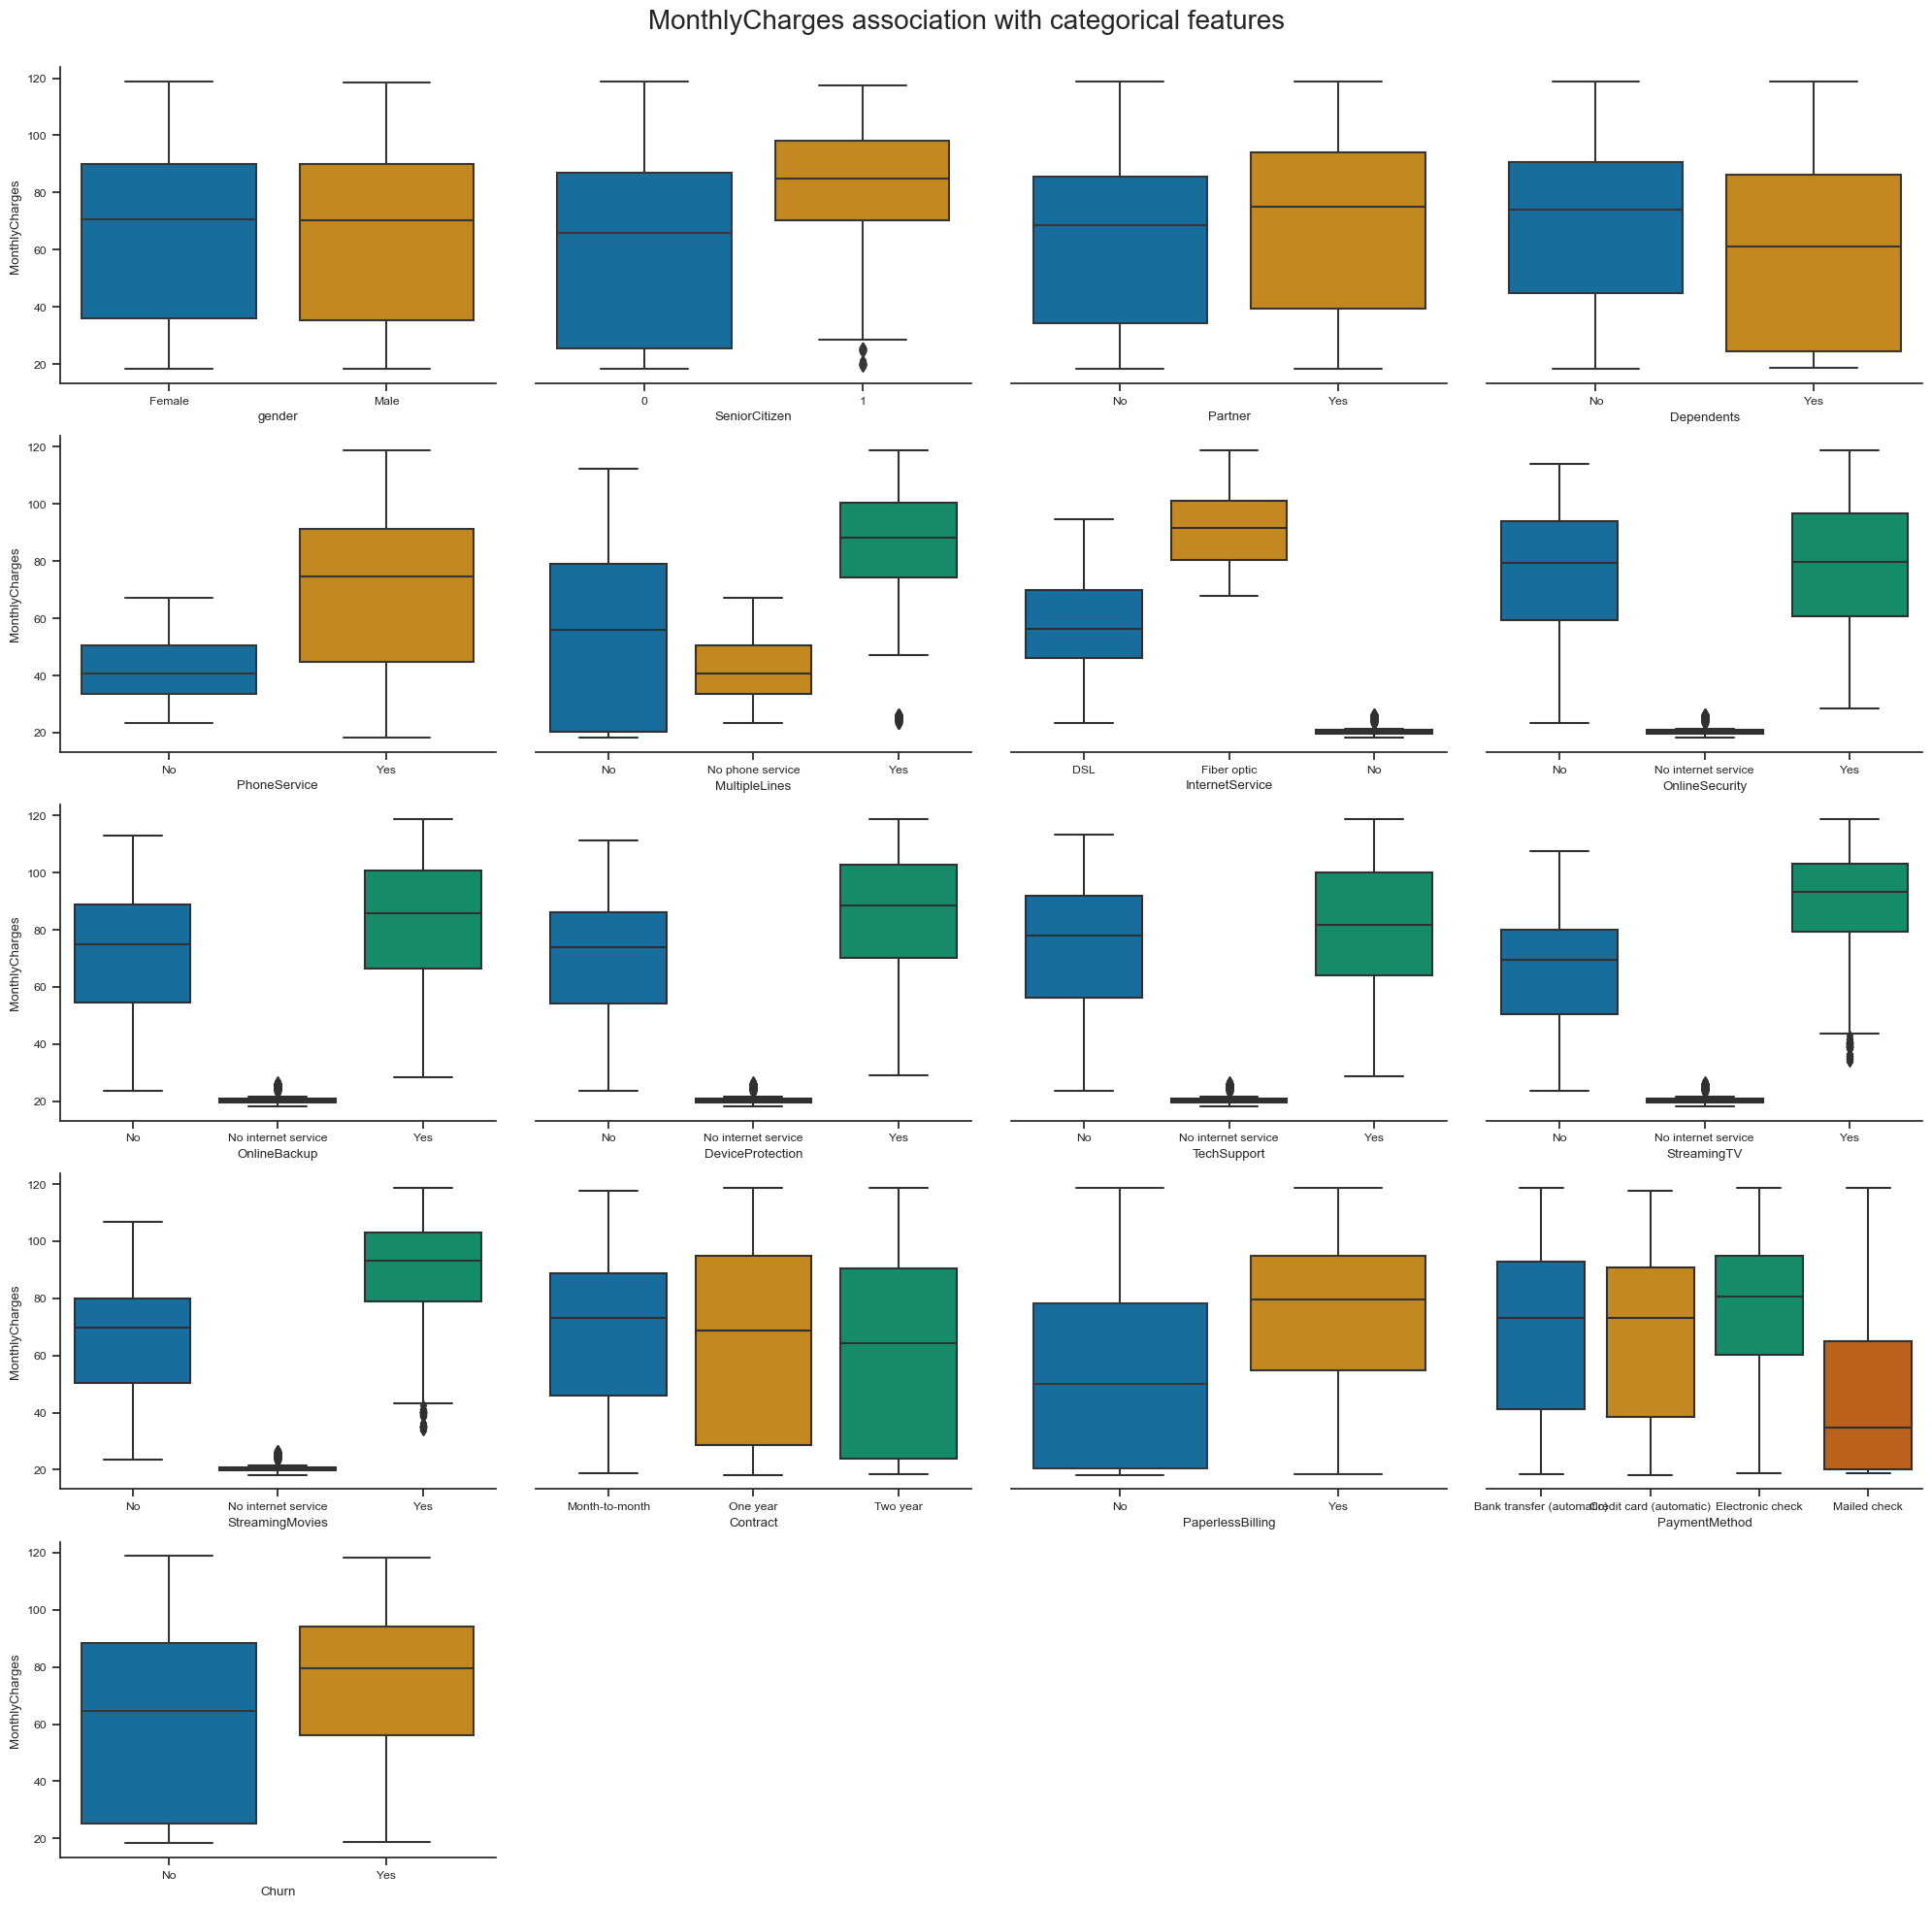

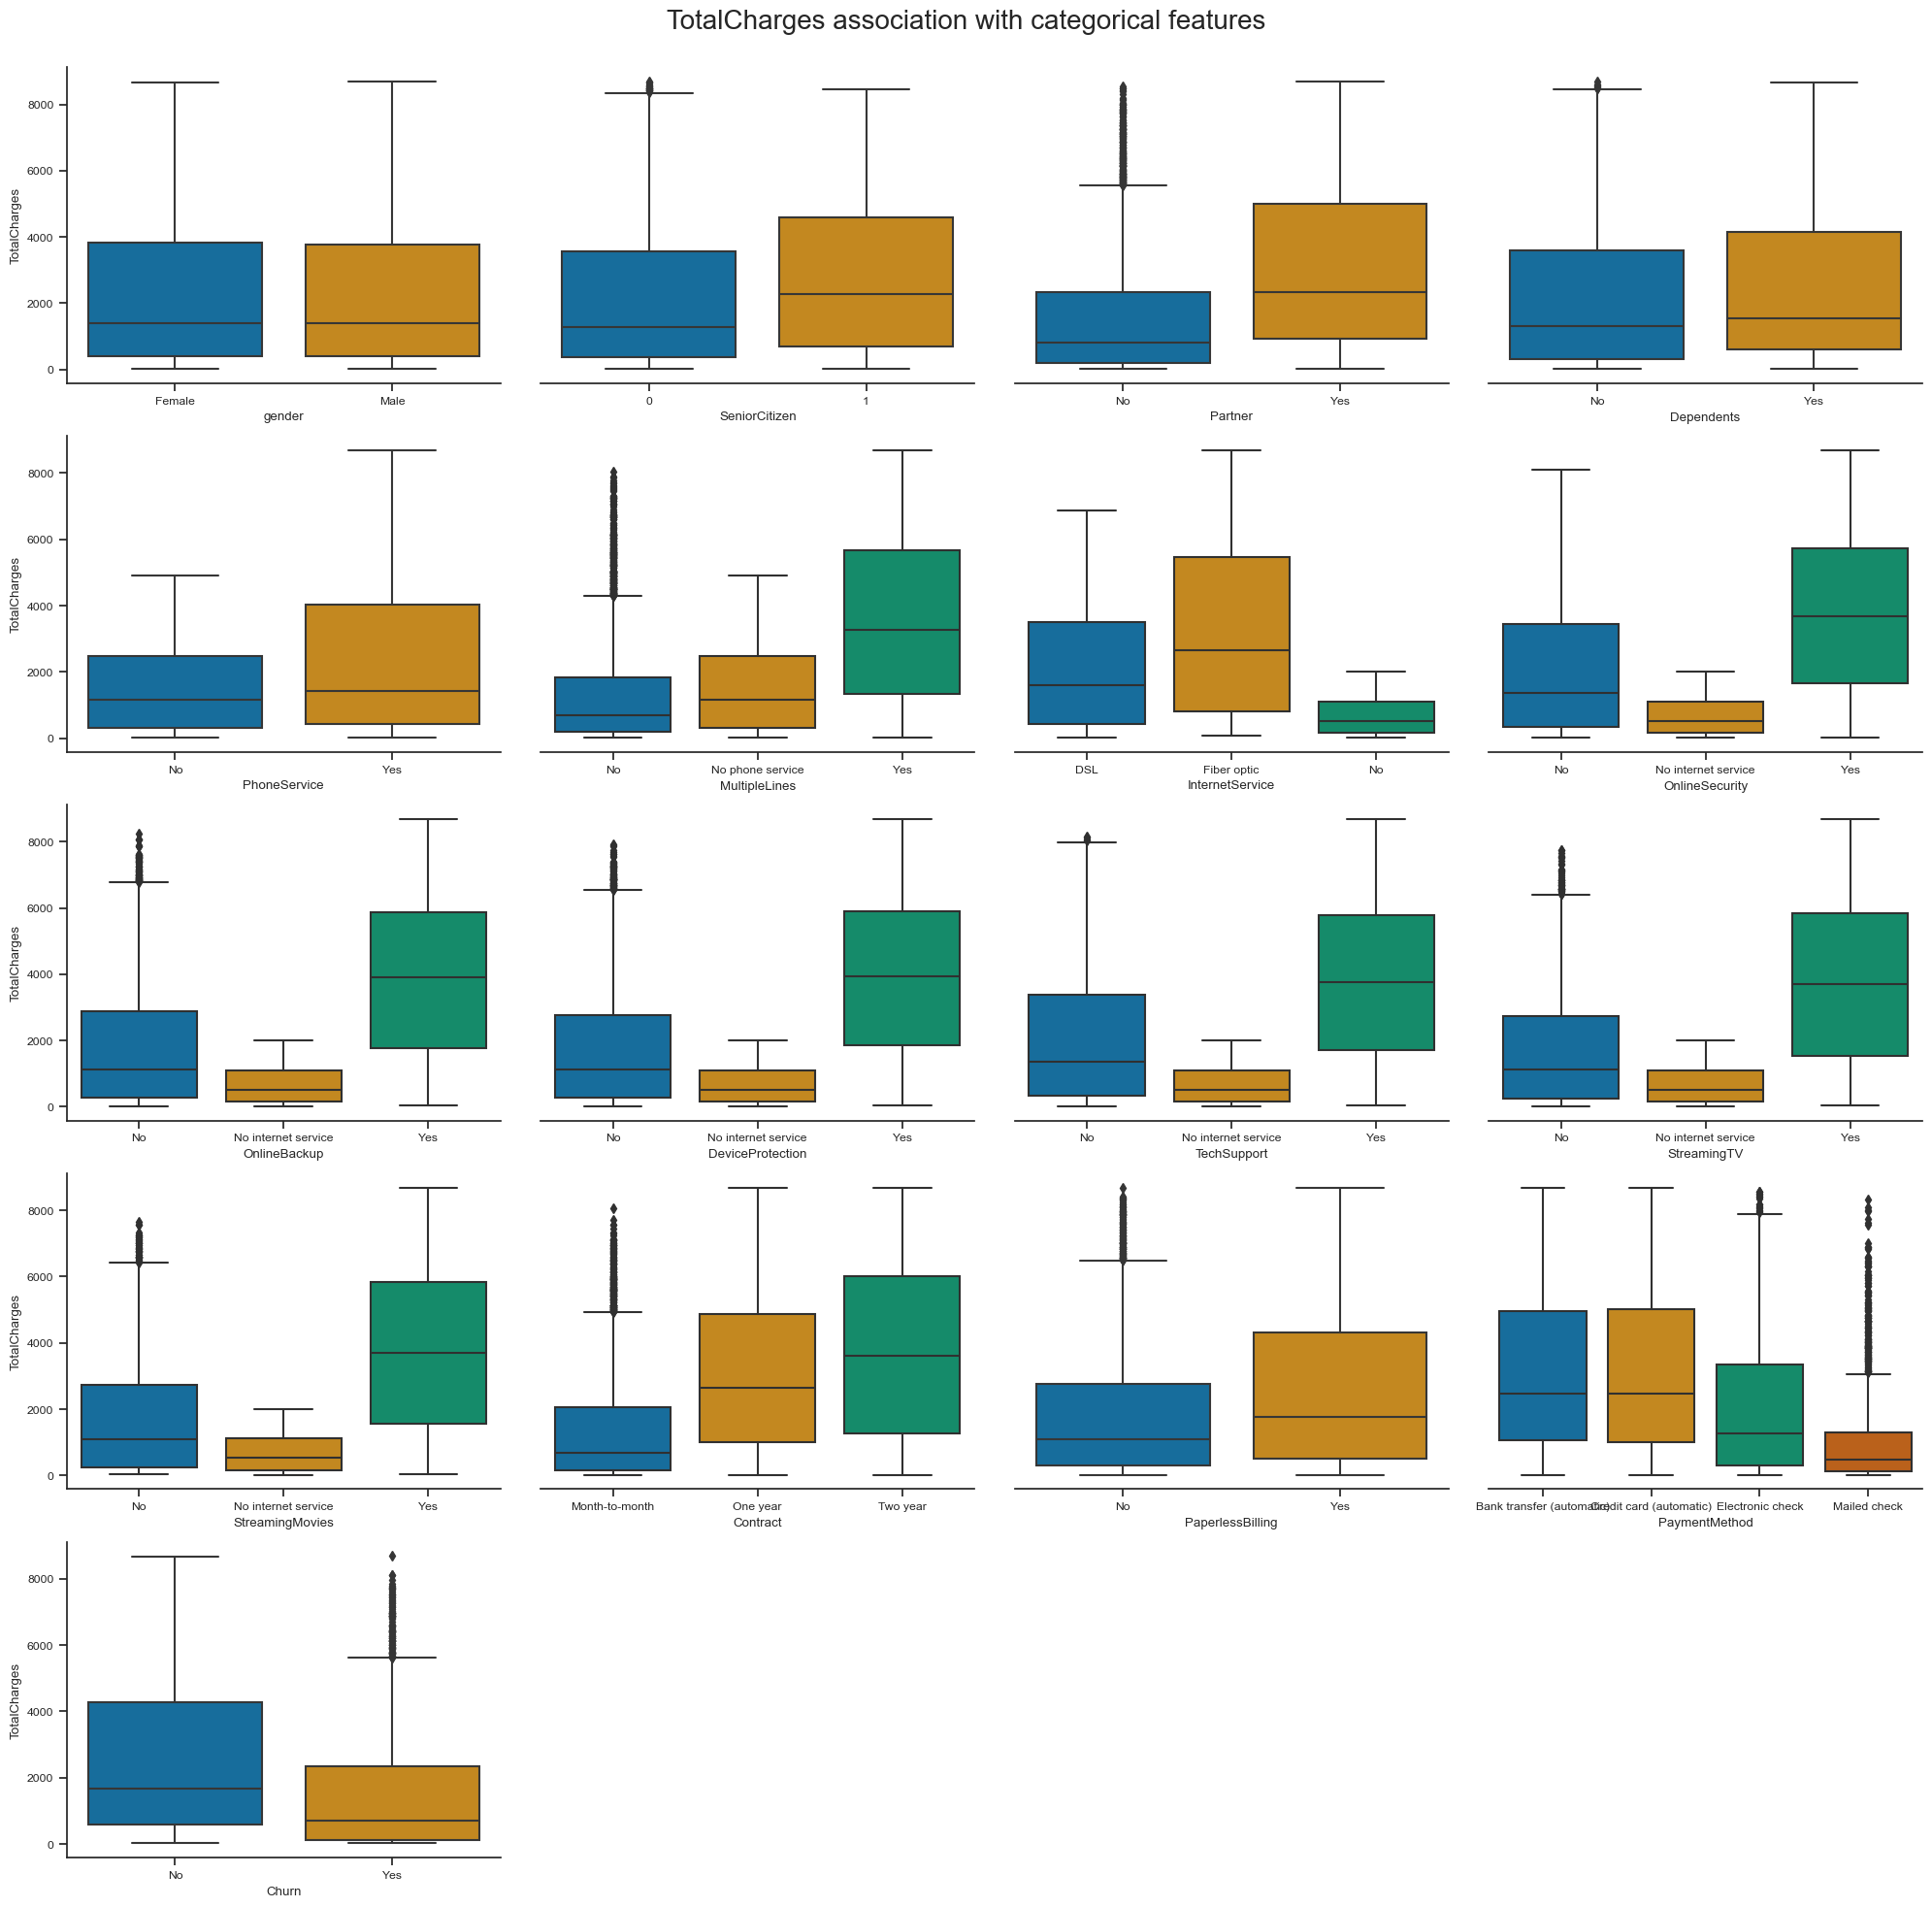

In [16]:
# Visualizing numerical features distribution by categories
ncols = 4
nrows = round((len(cat_cols) + 1) / ncols + .5)
for num_col in num_cols:
    fig, axes = plt.subplots(figsize=(20, 20), ncols=ncols, nrows=nrows, sharey="row")
    axes = axes.flatten()
    for i, cat_col in enumerate(cat_cols):
        sns.boxplot(data=df, y=num_col, x=cat_col, ax=axes[i])
        axes[i].set_ylabel("")
        axes[i].spines["top"].set_visible(False)
        axes[i].spines["right"].set_visible(False)
        if i % ncols == 0:
            axes[i].set_ylabel(num_col)
        else:
            axes[i].spines["left"].set_visible(False)
            axes[i].tick_params(axis="y", which="both", left=False)
    sns.boxplot(data=df, y=num_col, x="Churn", ax=axes[i+1])
    axes[i+1].spines["top"].set_visible(False)
    axes[i+1].spines["right"].set_visible(False)
    for ax in axes[len(cat_cols)+1:]:
        ax.set_axis_off()
    fig.suptitle(f"{num_col} association with categorical features", size=20)
    fig.tight_layout()
    fig.subplots_adjust(top=.95)

In [17]:
# Applying OneHotEncoder transformation on categorical features
transformer = ColumnTransformer(
    transformers=[("onehot", OneHotEncoder(drop="if_binary", sparse_output=False), cat_cols)],
    remainder="passthrough",
    verbose_feature_names_out=False
)

transformer.set_output(transform="pandas")
df_encoded = transformer.fit_transform(df)
df_encoded.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,InternetService_DSL,InternetService_Fiber optic,...,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,customerID,tenure,MonthlyCharges,TotalCharges,Churn
0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,7590-VHVEG,1,29.85,29.85,No
1,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,5575-GNVDE,34,56.95,1889.50,No
2,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,3668-QPYBK,2,53.85,108.15,Yes
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,7795-CFOCW,45,42.30,1840.75,No
4,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,9237-HQITU,2,70.70,151.65,Yes


#### 3.1.2.1 ANOVA and T-test

In [18]:
# Creating empty dataframe with numerical features as index and categorical features as columns
df_association = pd.DataFrame(index=num_cols,
                        columns=(list(cat_cols) + ["Churn"]))

In [19]:
df_association

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Churn
tenure,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MonthlyCharges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TotalCharges,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [20]:
# The empty dataframe will be filled with p-values of ANOVA for features with 3 categories or more and 
# T-test for features with 2 categories

In [21]:
for num_col in df_association.index:
    for cat_col in df_association.columns:
        cats2compare = []
        num_cats = len(df[cat_col].unique())
        if num_cats > 2:
            for cat in df[cat_col].unique():
                cats2compare.append(df[df[cat_col] == cat][num_col])
            _, p = f_oneway(*cats2compare)
            df_association.loc[num_col, cat_col] = p
        else:
            cat1, cat2 = df[cat_col].unique()
            _, p = ttest_ind(df[df[cat_col] == cat1][num_col],
                             df[df[cat_col] == cat2][num_col])
            df_association.loc[num_col, cat_col] = p

In [22]:
# Visualizing association: red (high p-value) means low association
df_association.apply(pd.to_numeric).T.style.background_gradient(cmap="Reds")

,tenure,MonthlyCharges,TotalCharges
gender,0.657665,0.247950,0.996800
SeniorCitizen,0.188504,0.000000,0.000000
Partner,0.000000,0.000000,0.000000
Dependents,0.000000,0.000000,0.000000
PhoneService,0.508957,0.000000,0.000000
MultipleLines,0.000000,0.000000,0.000000
InternetService,0.007053,0.000000,0.000000
OnlineSecurity,0.000000,0.000000,0.000000
OnlineBackup,0.000000,0.000000,0.000000
DeviceProtection,0.000000,0.000000,0.000000


## 3.2 Feature Selection

Firstly feature selection will be performed with RandomForestClassifier from sklearn.ensemble. Depending on models performance, insights of correlation and association will be used.
ct = ColumnTransformer() 

To properly use RandomForestClassifier categorical data must be encoded. For encoding just categorical columns, column transformer and 

In [23]:
# Pipeleine for categorical features encoding
ct = ColumnTransformer(
    transformers=[
        ("onehot", OneHotEncoder(sparse_output=False, drop="if_binary"), cat_cols + ["Churn"])
    ],
    remainder="passthrough",
    verbose_feature_names_out=False
)

# Define output as pandas dataframe
ct.set_output(transform="pandas")

# Enconding categorical features
df_encoded = ct.fit_transform(df.loc[:, cat_cols + num_cols + ["Churn"]])

In [24]:
# Data separation between train and test using train_test_split function
X = df_encoded.drop(labels="Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [25]:
print(X_train.shape, y_train.shape)

(5625, 40) (5625,)


In [26]:
# Using RandomForestClassifier with 100 estimators for select important features
selector = SelectFromModel(RandomForestClassifier(n_estimators=100))
selector.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

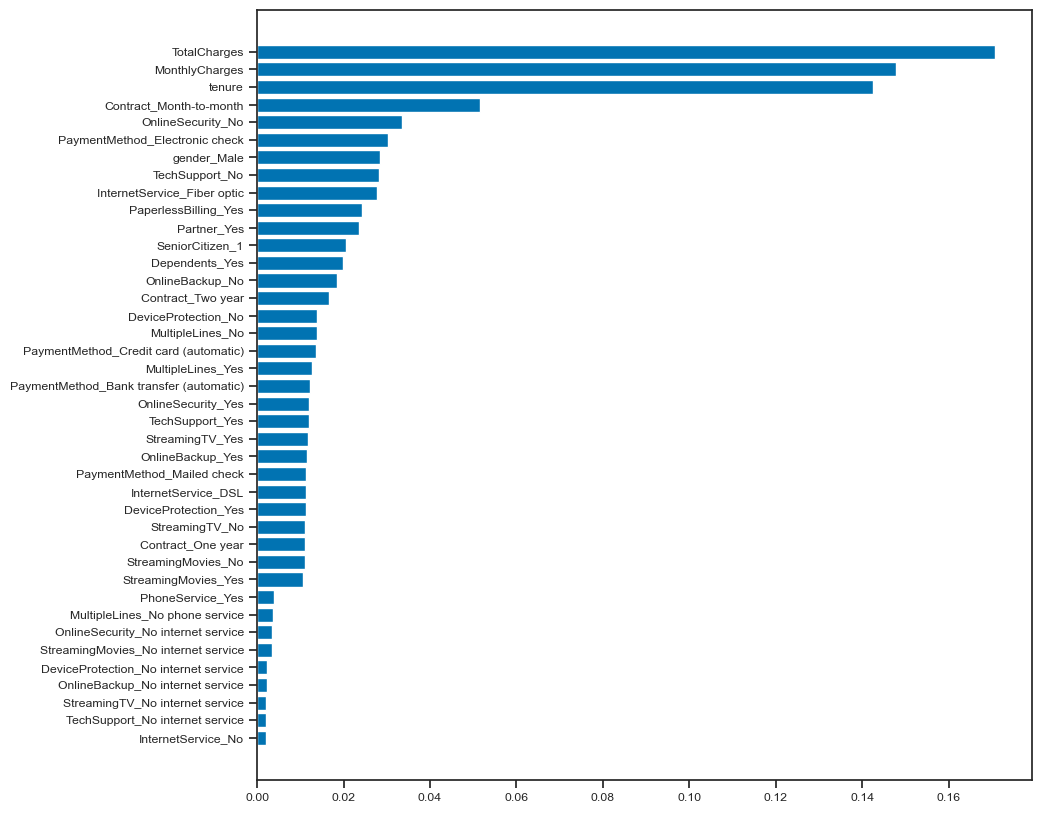

In [27]:
# Visualizing feature importances
importances = list(
    zip(selector.feature_names_in_,
        selector.estimator_.feature_importances_)
    )

importances.sort(key=lambda x: x[1])
fig = plt.figure(figsize=(10, 10))
plt.barh([x[0] for x in importances], [x[1] for x in importances]);

In [28]:
# Features that must be dropped accordingly with get_support() method
feat2be_dropped = list(zip(selector.get_support(), selector.feature_names_in_))
feat2be_dropped = [x[1] for x in feat2be_dropped if x[0]==False]

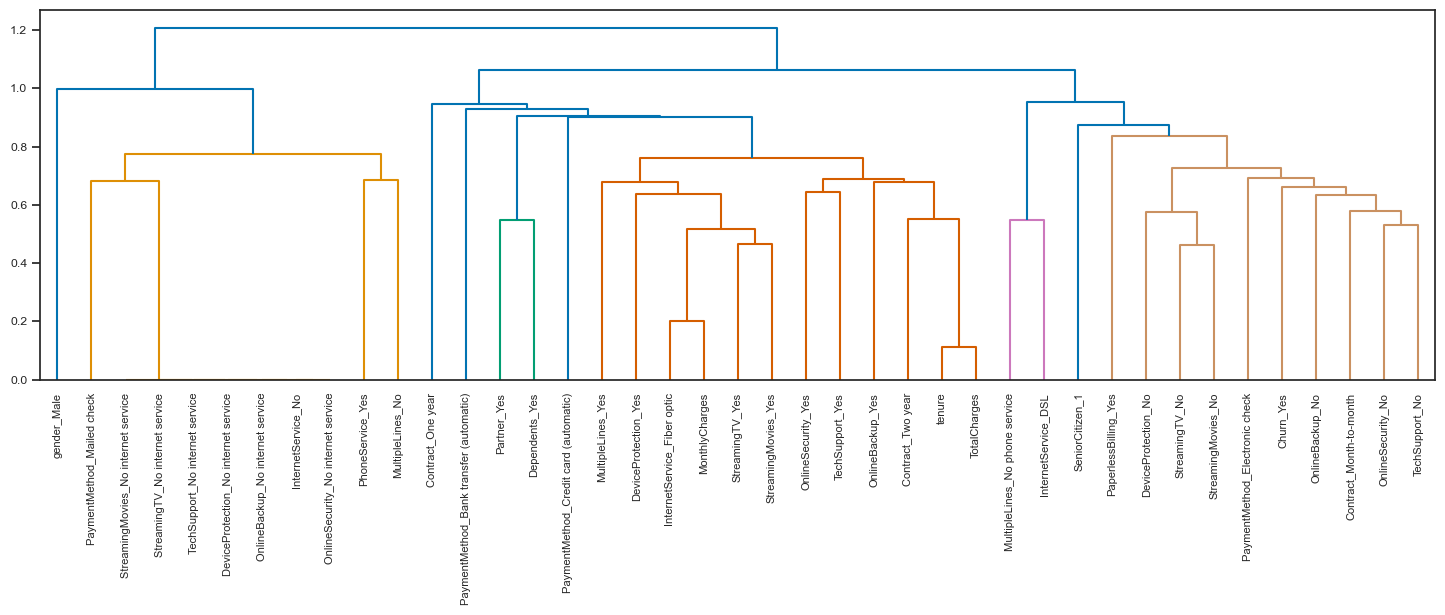

In [29]:
# Sepearman's rho dendrogram
spearman_corr = np.round(spearmanr(df_encoded).correlation, 4)
corr_condensed = distance.squareform(1- spearman_corr)
z = linkage(corr_condensed, method="average")
fig = plt.figure(figsize=(18, 4.8))
dendrogram(z, labels=df_encoded.columns);

 From RandomForestClassifier feature importances and By Spearman's rho dengrogram  the following features will be dropped:
- SeniorCitizen_1
- Partner_Yes
- Dependents_Yes
- PhoneService_Yes
- MultipleLines_No
- MultipleLines_No phone service
- MultipleLines_Yes
- InternetService_DSL
- InternetService_No
- OnlineSecurity_No internet service
- OnlineSecurity_Yes
- OnlineBackup_No
- OnlineBackup_No internet service
- OnlineBackup_Yes
- DeviceProtection_No
- DeviceProtection_No internet service
- DeviceProtection_Yes
- TechSupport_No internet service
- TechSupport_Yes
- StreamingTV_No
- StreamingTV_No internet service
- StreamingTV_Yes
- StreamingMovies_No
- StreamingMovies_No internet service
- StreamingMovies_Yes
- Contract_One year
- Contract_Two year
- PaperlessBilling_Yes
- PaymentMethod_Bank transfer (automatic)
- PaymentMethod_Credit card (automatic)
- PaymentMethod_Mailed check
- tenure
- InternetService_Fiber optic

## 4 - Data Modeling
In this sections, models will be implemented according to selected features with RandomForestClassifier and mutual_info_classif.

In [30]:
# Data separation between train and test using train_test_split function and dropping features accordingo to 3.2
cols2drop = [
    "Churn_Yes",
    "SeniorCitizen_1",
    "Partner_Yes",
    "Dependents_Yes",
    "PhoneService_Yes",
    "MultipleLines_No",
    "MultipleLines_No phone service",
    "MultipleLines_Yes",
    "InternetService_DSL",
    "InternetService_No",
    "OnlineSecurity_No internet service",
    "OnlineSecurity_Yes",
    "OnlineBackup_No",
    "OnlineBackup_No internet service",
    "OnlineBackup_Yes",
    "DeviceProtection_No",
    "DeviceProtection_No internet service",
    "DeviceProtection_Yes",
    "TechSupport_No internet service",
    "TechSupport_Yes",
    "StreamingTV_No",
    "StreamingTV_No internet service",
    "StreamingTV_Yes",
    "StreamingMovies_No",
    "StreamingMovies_No internet service",
    "StreamingMovies_Yes",
    "Contract_One year",
    "Contract_Two year",
    "PaperlessBilling_Yes",
    "PaymentMethod_Bank transfer (automatic)",
    "PaymentMethod_Credit card (automatic)",
    "PaymentMethod_Mailed check",
    "tenure",
    "InternetService_Fiber optic"
    ]
X = df_encoded.drop(labels=cols2drop, axis=1)
y = df_encoded["Churn_Yes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### 4.1 - Logistic Regression

In [31]:
lr = LogisticRegression(random_state=0, max_iter=1000)
lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=0)

### 4.2 - Decision Tree

In [32]:
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(random_state=0)

### 4.3 - XGBoost

In [33]:
xgb_ = xgb.XGBClassifier()
xgb_.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### 4.4 - LightGBM


In [34]:
lgb_ = lgb.LGBMClassifier()
lgb_.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 520
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


LGBMClassifier()

### 4.5 - Random Forest

In [35]:
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=0)

### 4.6 - Neural Networks

In [36]:
MLP = MLPClassifier(random_state=0)
MLP.fit(X_train, y_train)

MLPClassifier(random_state=0)

## 5 - Model Evaluation

In [37]:
def evaluate_model(model):
    y_pred = model.predict(X_test)
    acc = metrics.accuracy_score(y_pred, y_test)
    bal_acc = metrics.balanced_accuracy_score(y_pred, y_test)
    recall = metrics.recall_score(y_pred, y_test)
    precision = metrics.precision_score(y_pred, y_test)
    f1 = metrics.f1_score(y_pred, y_test)
    ROC = metrics.roc_auc_score(y_pred, y_test)

    results = {"accuracy": acc,
               "balanced_accuracy": bal_acc,
               "recall": recall,
               "precision": precision,
               "f1_score": f1,
               "ROC": ROC}
    return pd.DataFrame(results, index=[0]).T

def confusion_matrix(model, ax):
    return metrics.ConfusionMatrixDisplay.from_estimator(model, X_test, y_test,
                                                         labels=model.classes_,
                                                         cmap="Blues", ax=ax);

In [38]:
models = [lr, dtree, xgb_, lgb_, rf, MLP]
evaluated_models = [evaluate_model(x) for x in models]
model_names = ["Logistic Regression",
               "Decision Tree",
               "XGBoost",
               "LightGBM",
               "Random Forest",
               "MLP Classifier"]

In [39]:
display_side_by_side(evaluated_models,
                     captions=model_names)

,0
accuracy,0.781095
balanced_accuracy,0.718376
recall,0.605096
precision,0.508021
f1_score,0.552326
ROC,0.718376
,0
accuracy,0.734186
balanced_accuracy,0.658566
recall,0.500000


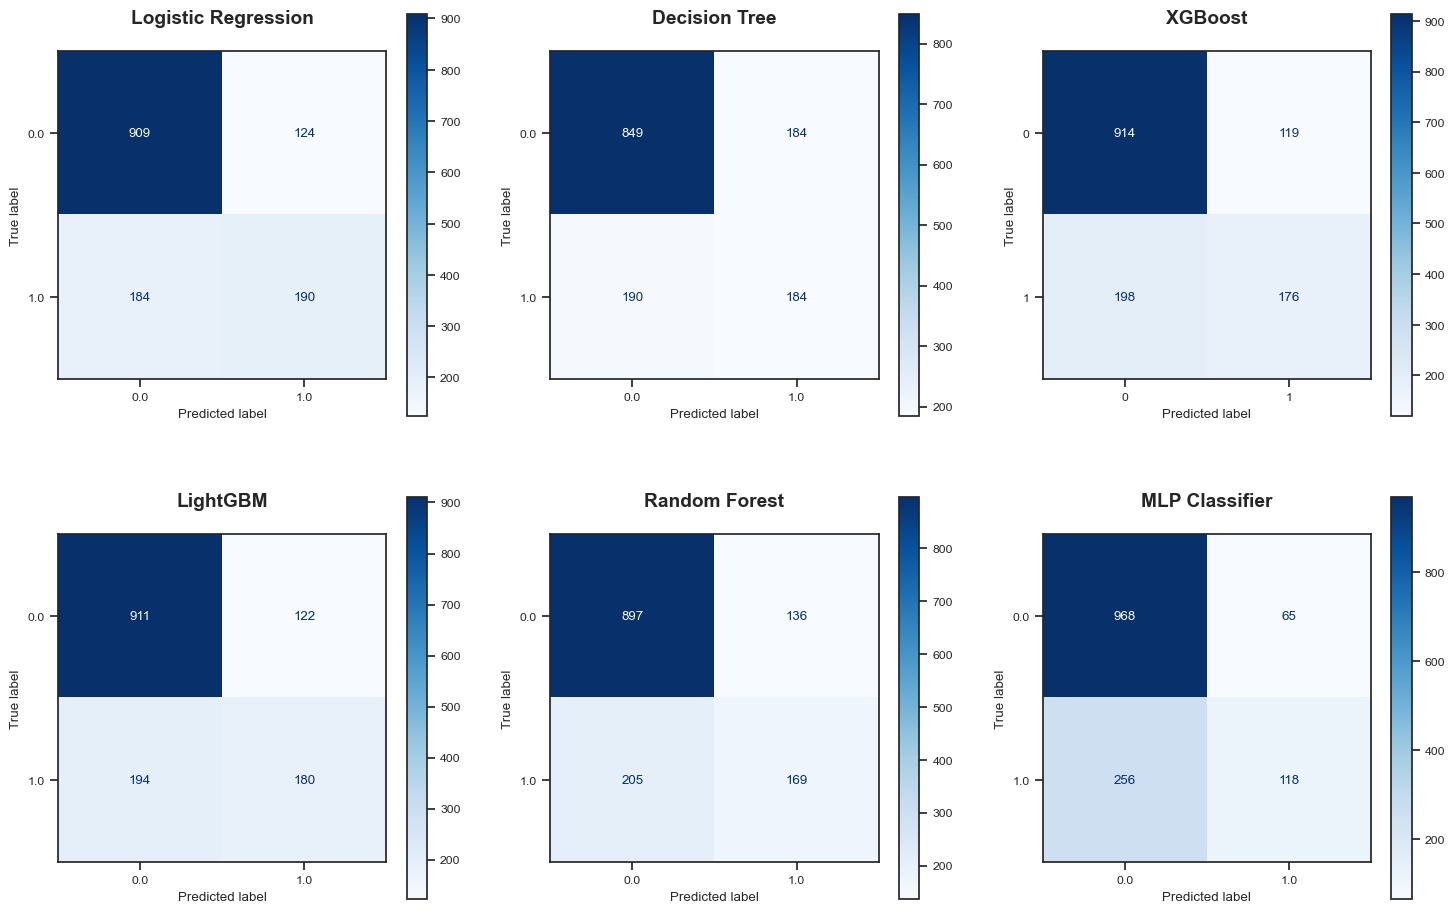

In [40]:
fig, axes = plt.subplots(figsize=(18, 11.5), nrows=2, ncols=3)
for model, name, ax in zip(models, model_names, axes.flatten()):
    ax.set_title(name)
    confusion_matrix(model, ax)

Let's train models again, but now using whole dataset features.

In [41]:
# Declaring classifiers and target
X = df_encoded.drop(labels="Churn_Yes", axis=1)
y = df_encoded["Churn_Yes"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [42]:
# Logistic Regression
lr = LogisticRegression(random_state=0, max_iter=1000)
lr.fit(X_train, y_train)

# Decision Tree
dtree = DecisionTreeClassifier(random_state=0)
dtree.fit(X_train, y_train)

# XGBoost
xgb_ = xgb.XGBClassifier()
xgb_.fit(X_train, y_train)

# LightGBM
lgb_ = lgb.LGBMClassifier()
lgb_.fit(X_train, y_train)

# Random Forest
rf = RandomForestClassifier(random_state=0, n_jobs=-1)
rf.fit(X_train, y_train)

# Neural Networks
MLP = MLPClassifier(random_state=0)
MLP.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1495, number of negative: 4130
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 657
[LightGBM] [Info] Number of data points in the train set: 5625, number of used features: 40
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.265778 -> initscore=-1.016151
[LightGBM] [Info] Start training from score -1.016151


MLPClassifier(random_state=0)

In [43]:
models = [lr, dtree, xgb_, lgb_, rf, MLP]
evaluated_models = [evaluate_model(x) for x in models]
model_names = ["Logistic Regression",
               "Decision Tree",
               "XGBoost",
               "LightGBM",
               "Random Forest",
               "MLP Classifier"]

In [44]:
display_side_by_side(evaluated_models,
                     captions=model_names)

,0
accuracy,0.788913
balanced_accuracy,0.729609
recall,0.622222
precision,0.524064
f1_score,0.568940
ROC,0.729609
,0
accuracy,0.717129
balanced_accuracy,0.641484
recall,0.469543


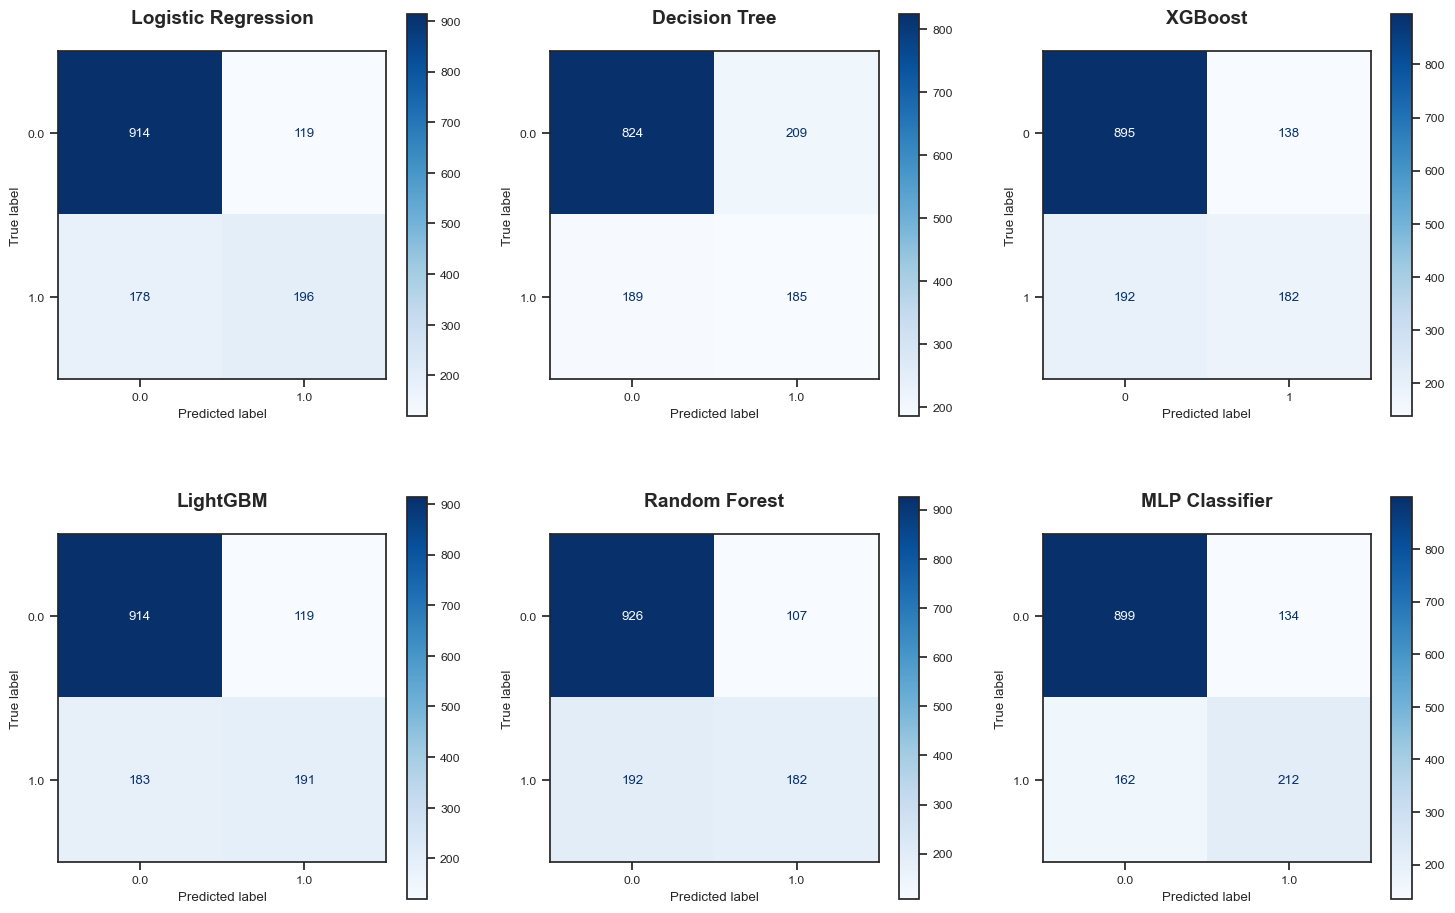

In [45]:
fig, axes = plt.subplots(figsize=(18, 11.5), nrows=2, ncols=3)
for model, name, ax in zip(models, model_names, axes.flatten()):
    ax.set_title(name)
    confusion_matrix(model, ax)

The models trained without dropping less important features, according to SelectFromModel, had best performance in general. In Churn Prediction it's importante to identify actual churn clients (TP- *true Positives*) but also minimize clients classifieds as churn that aren't actual churn. In this way, we avoid to expend money with no churn clients. Therefore the models are selected with basis on precision, because precision are calculated with TP and FP (*false positive*).

$Precision = \frac{TP}{TP + FP}$

The FP in denominator penalizes the metric according to the presence of FP and VP in numerator rewards the presence of true positives. The Logistic Regression and MLP (*multi-layer perceptron*) Classifier are chosen as models for the problem. Then these models will pass for an Hyperparameter Tuning step.

### 5.1 - Hyperparameter Tuning

In this section we will find hyperparameters that increase the precision value through RandomizedSearchCV.
RandomizeSearchCV perform a random search on hyper parameters and is available in [scikit-klearn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html).

#### 5.1.1 LogisticRegression parameters

In [46]:
# LogisticRegression parameters
lr.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 1000,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [47]:
# LogisticRegression chosen parameters
lr_parameters = {
    "C": [.01, .1, 1, 10],
    "penalty": ["l1", "l2", "elasticnet"],
    "solver":  ["lbfgs", "liblinear", "newton-cholesky"],
    "warm_start": [True, False]
}

#### 5.1.2 MLPClassifier parameters

In [48]:
# MLPClassifier parameters
MLP.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': 0,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [49]:
# MLPClassifier chosen parameters
MLP_parameters = {
    "activation": ["relu", "logistic", "tanh"],
    "learning_rate": ["constant", "adaptive"],
    "learning_rate_init": [.001, .005, .01],
    "warm_start": [False, True],
    "solver": ["lbfgs", "sgd", "adam"],
    "hidden_layer_sizes": [(50,50,50), (50,100,50), (100,)]
}

#### 5.1.3 - Run RandomizedSearch for both models

In [50]:
# Perform RandomizedSearchCV for LogisticRegression]
lr_cv = RandomizedSearchCV(lr, lr_parameters, random_state=0, scoring="precision")
lr_cv.fit(X_train, y_train)
lr_cv.best_params_

c:\Users\gui_p\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
35 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\gui_p\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\gui_p\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\linear_model\_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "c:\Users\gui_p\AppData\Local\Programs\Pyth

{'warm_start': False, 'solver': 'lbfgs', 'penalty': 'l2', 'C': 0.01}

In [51]:
# Perform RandomizedSearchCV for MLPClassifier 
MLP_cv = RandomizedSearchCV(MLP, MLP_parameters, random_state=0, scoring="precision")
MLP_cv.fit(X_train, y_train)
MLP_cv.best_params_

c:\Users\gui_p\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\gui_p\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
c:\Users\gui_p\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\neural_network\_multilayer_perceptr

{'warm_start': True,
 'solver': 'adam',
 'learning_rate_init': 0.005,
 'learning_rate': 'adaptive',
 'hidden_layer_sizes': (50, 100, 50),
 'activation': 'relu'}

### 5.2 - Evaluation after parameter tuning

In [52]:
models = [lr_cv, MLP_cv]
evaluated_models = [evaluate_model(x) for x in models]
model_names = ["Logistic Regression",
               "MLP Classifier"]

In [53]:
display_side_by_side(evaluated_models, model_names)

,0
accuracy,0.786780
balanced_accuracy,0.727706
recall,0.626712
precision,0.489305
f1_score,0.549550
ROC,0.727706
,0
accuracy,0.722814
balanced_accuracy,0.673976
recall,0.484674


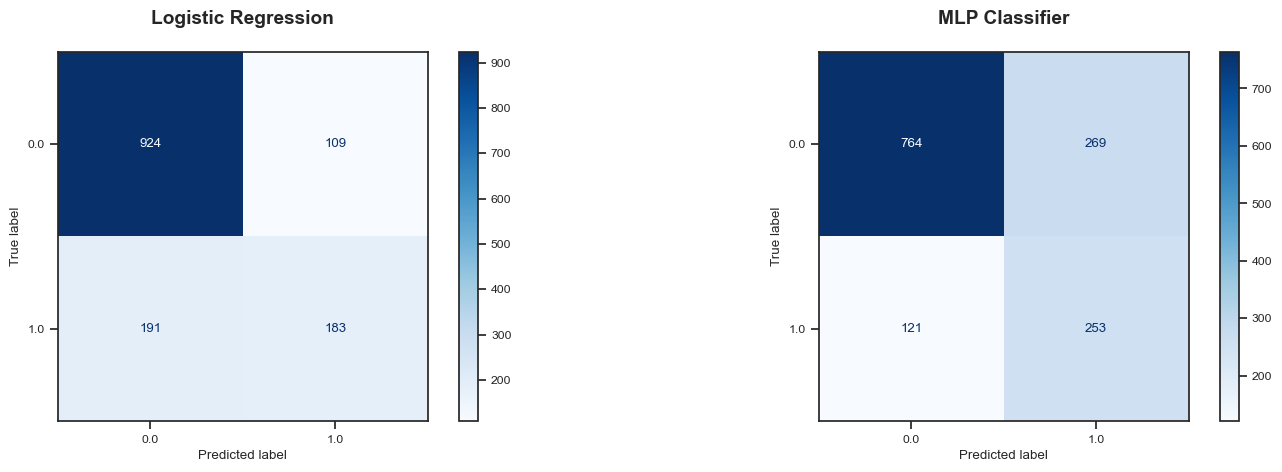

In [54]:
fig, axes = plt.subplots(figsize=(18, 4.8), ncols=2)
for model, name, ax in zip(models, model_names, axes.flatten()):
    ax.set_title(name)
    confusion_matrix(model, ax)

The MLP model increased precision but alghouth true positives have increased, False Positives also increased. It was expected a true positive increasing without increasing false positives.
Let's try changing threshold to evaluate again this model.

In [55]:
probability = MLP_cv.predict_proba(X_test)

In [56]:
y_pred = (probability[:, 1] > 0.6).astype(int)

In [57]:
print(f"accuracy: {metrics.accuracy_score(y_test, y_pred)}")
print(f"precision: {metrics.precision_score(y_test, y_pred)}")
print(f"recall: {metrics.recall_score(y_test, y_pred)}")
print(f"f1-score: {metrics.f1_score(y_test, y_pred)}")
print(f"ROC: {metrics.roc_auc_score(y_test, y_pred)}")

accuracy: 0.7846481876332623
precision: 0.6485355648535565
recall: 0.4144385026737968
f1-score: 0.5057096247960848
ROC: 0.6665609744733941


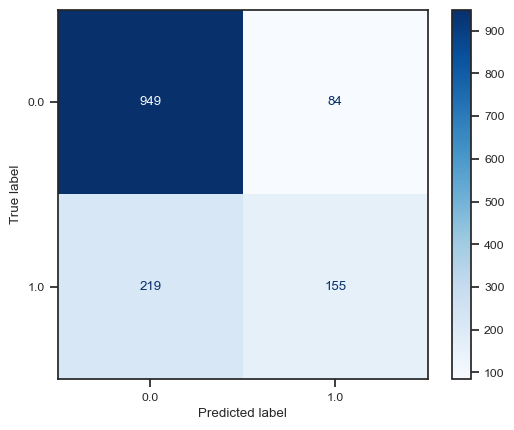

In [58]:
metrics.ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")

Now we had increased the number of false negatives. In churn prediction context we would we would left to do campaing with churn customers and possibly lose them. In my opinion, we could follow with MLP without threshhold. LogisticRegression have precision decreased with RandomSearchCV.
